# Setup Inicial

In [1]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random

#Essentials

import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd
from itables import show
from scipy.optimize import curve_fit

#from objproxies import *

import matplotlib.pyplot as plt

#Qiskit

from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import qiskit_aer

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Estimators

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

from qiskit_ibm_runtime import Estimator 

from qiskit_ibm_runtime import EstimatorV2

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *


%matplotlib widget
#%matplotlib inline


provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)

mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

circuito_ibm = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), backend)

hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = JordanWignerMapper().map(hamiltoniano).num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito_ibm.data:

    if all(circuito_ibm.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito_ibm.qubits.index(qubit) for qubit in gate[1]])

circuito_ibm = new_circuit

# Funções Globais

In [2]:
def salvar(a):
    with open(f'AWS/Gabriel/GroundState2/dados/{a}.pickle', 'wb') as f:
        pickle.dump(eval(a), f) 

def abrir(a):
    with open(f'AWS/Gabriel/GroundState2/dados/{a}.pickle', 'rb') as f:
        return pickle.load(f)
    
def clifford_gate():

   random_value = random.randint(0, 3)
   
   return RZGate(random_value*np.pi/2)

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit

   if shots != None:
   
      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   else :

      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, approximation = True, skip_transpilation = skip_transpilation)
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, approximation = True, skip_transpilation = skip_transpilation)
      
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer_noise(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True, noise_model = None, coupling_map = None):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   estimator = Estimator_Aer(backend_options={'noise_model': noise_model}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)         
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

ESTIMATORS = {
    'statevector': run_statevector,
    'estimator': run_estimator,
    'estimator_aer': run_estimator_aer,
    'estimator_aer_noise': run_estimator_aer_noise,
}

def check(original_value, target, driver, difference_percentage, estimator_name='statevector', **kwargs):
    estimator_function = ESTIMATORS[estimator_name]
    target_value = estimator_function(target, driver, **kwargs)
    return abs(original_value - target_value) < difference_percentage * abs(original_value), target_value

# Funções de Gates

In [9]:
    
def clifford_gate():

   random_value = random.randint(0, 3)
   
   return RZGate(random_value*np.pi/2)

def cnot_gate(qr):
   
   control_qubit = random.randint(0, len(qr) - 1)
   
   target_qubit = random.choice([i for i in range(len(qr)) if i != control_qubit])
   
   return CXGate(), (control_qubit, target_qubit)

 
def crz_gate():
   
   random_value = random.randint(0, 3)

   crz_gate = CRZGate(random_value * np.pi / 2)

   return crz_gate

# Modelo 1

troca quaisquer gates de 1 qubit para rotação Rz

In [4]:

def subs_ncg(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   non_permitted_gates = ["cx", "ecr"]

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
      
         if gate.name not in non_permitted_gates:
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)

         else:
            
            new_gate = random.randint(i, len(quantum_circuit.data)-1)
            
            #while quantum_circuit.data[new_gate][0].name in non_permitted_gates or new_gate in gates_to_change:
            while quantum_circuit.data[new_gate][0].name in non_permitted_gates:
                
                new_gate = random.randint(i, len(quantum_circuit.data)-1)

            quantum_circuit.data[new_gate] = (clifford_gate(), *quantum_circuit.data[new_gate][1:])

   return quantum_circuit

def modelo_1(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        new_circuit = subs_ncg(original_circuit, percentage_of_changed_gates)
        
        if do_check:
            
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            
            if check_result:
                number_of_circuits -= 1
                yield new_circuit, target_value
        else:
            number_of_circuits -= 1
            yield new_circuit
  

# Modelo 2

troca apenas rotações Rz por Rz de clifford

In [5]:

def subs_cg_rz(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   if n > quantum_circuit.size() + 1:
       
       raise ValueError("n muito grande.")

   permitted_gates = ["rz"]

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
      
         if gate.name in permitted_gates:
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)

         else:
            
            new_gate = random.randint(i, len(quantum_circuit.data)-1)
            
            while quantum_circuit.data[new_gate][0].name not in permitted_gates:
                
                new_gate = random.randint(i, len(quantum_circuit.data)-1)

            quantum_circuit.data[new_gate] = (clifford_gate(), *quantum_circuit.data[new_gate][1:])

   return quantum_circuit

def modelo_2(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        new_circuit = subs_cg_rz(original_circuit, percentage_of_changed_gates)
        
        if do_check:
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            if check_result:
                number_of_circuits -= 1
                yield new_circuit, target_value
        else:
            number_of_circuits -= 1
            yield new_circuit
        

# Modelo 3

troca todos os gates do sistema por gates de clifford:


1 qubit - Rz de clifford

2 qubit - cnot com target e control escolhidos randomicamente

In [6]:
def subs_all(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   if n > quantum_circuit.size() + 1:
       raise ValueError("N errado.")

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   qr = quantum_circuit.qregs[0]

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
            
        if gate.num_qubits == 1:

            quantum_circuit.data[i] = (clifford_gate(), *qubits)

        elif gate.num_qubits == 2:

            gate, qubits = cnot_gate(qr)

            quantum_circuit.data[i] = (gate, qubits, [])

   return quantum_circuit

def modelo_3(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        
        new_circuit = subs_all(original_circuit, percentage_of_changed_gates)
        
        if do_check:
        
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            
            if check_result:
            
                number_of_circuits -= 1
                yield new_circuit, target_value
        
        else:
        
            number_of_circuits -= 1
            yield new_circuit

# Modelo 4

troca apenas Rz e 2 qubit gates:


Rz - Rz de clifford

2 qubit - Control Rz de clifford

In [7]:
def subs_rz_cnot(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   if n > quantum_circuit.size() + 1:
       raise ValueError("N errado.")

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
            
        if isinstance(gate, RZGate):
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)
        
        elif gate.num_qubits == 2:
        
            quantum_circuit.data[i] = (crz_gate(), *qubits)

   return quantum_circuit

def modelo_4(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        new_circuit = subs_rz_cnot(original_circuit, percentage_of_changed_gates)
        
        if do_check:
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            
            if check_result:
            
                number_of_circuits -= 1
                yield new_circuit, target_value
        
        else:
        
            number_of_circuits -= 1
            yield new_circuit

# Testando modelos

In [55]:
for gate, qubits, etc in circuito_ibm.data:
    
    print(gate, qubits, etc)

Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.5707963267948966]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.570796326794897]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]) [Qubit(QuantumRegister(4, 'q'), 1)] []
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]) [Qubit(QuantumRegister(4, 'q'), 1)] []
Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]) [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[3.1014157665866042]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-3.141592653589793]) [Qu

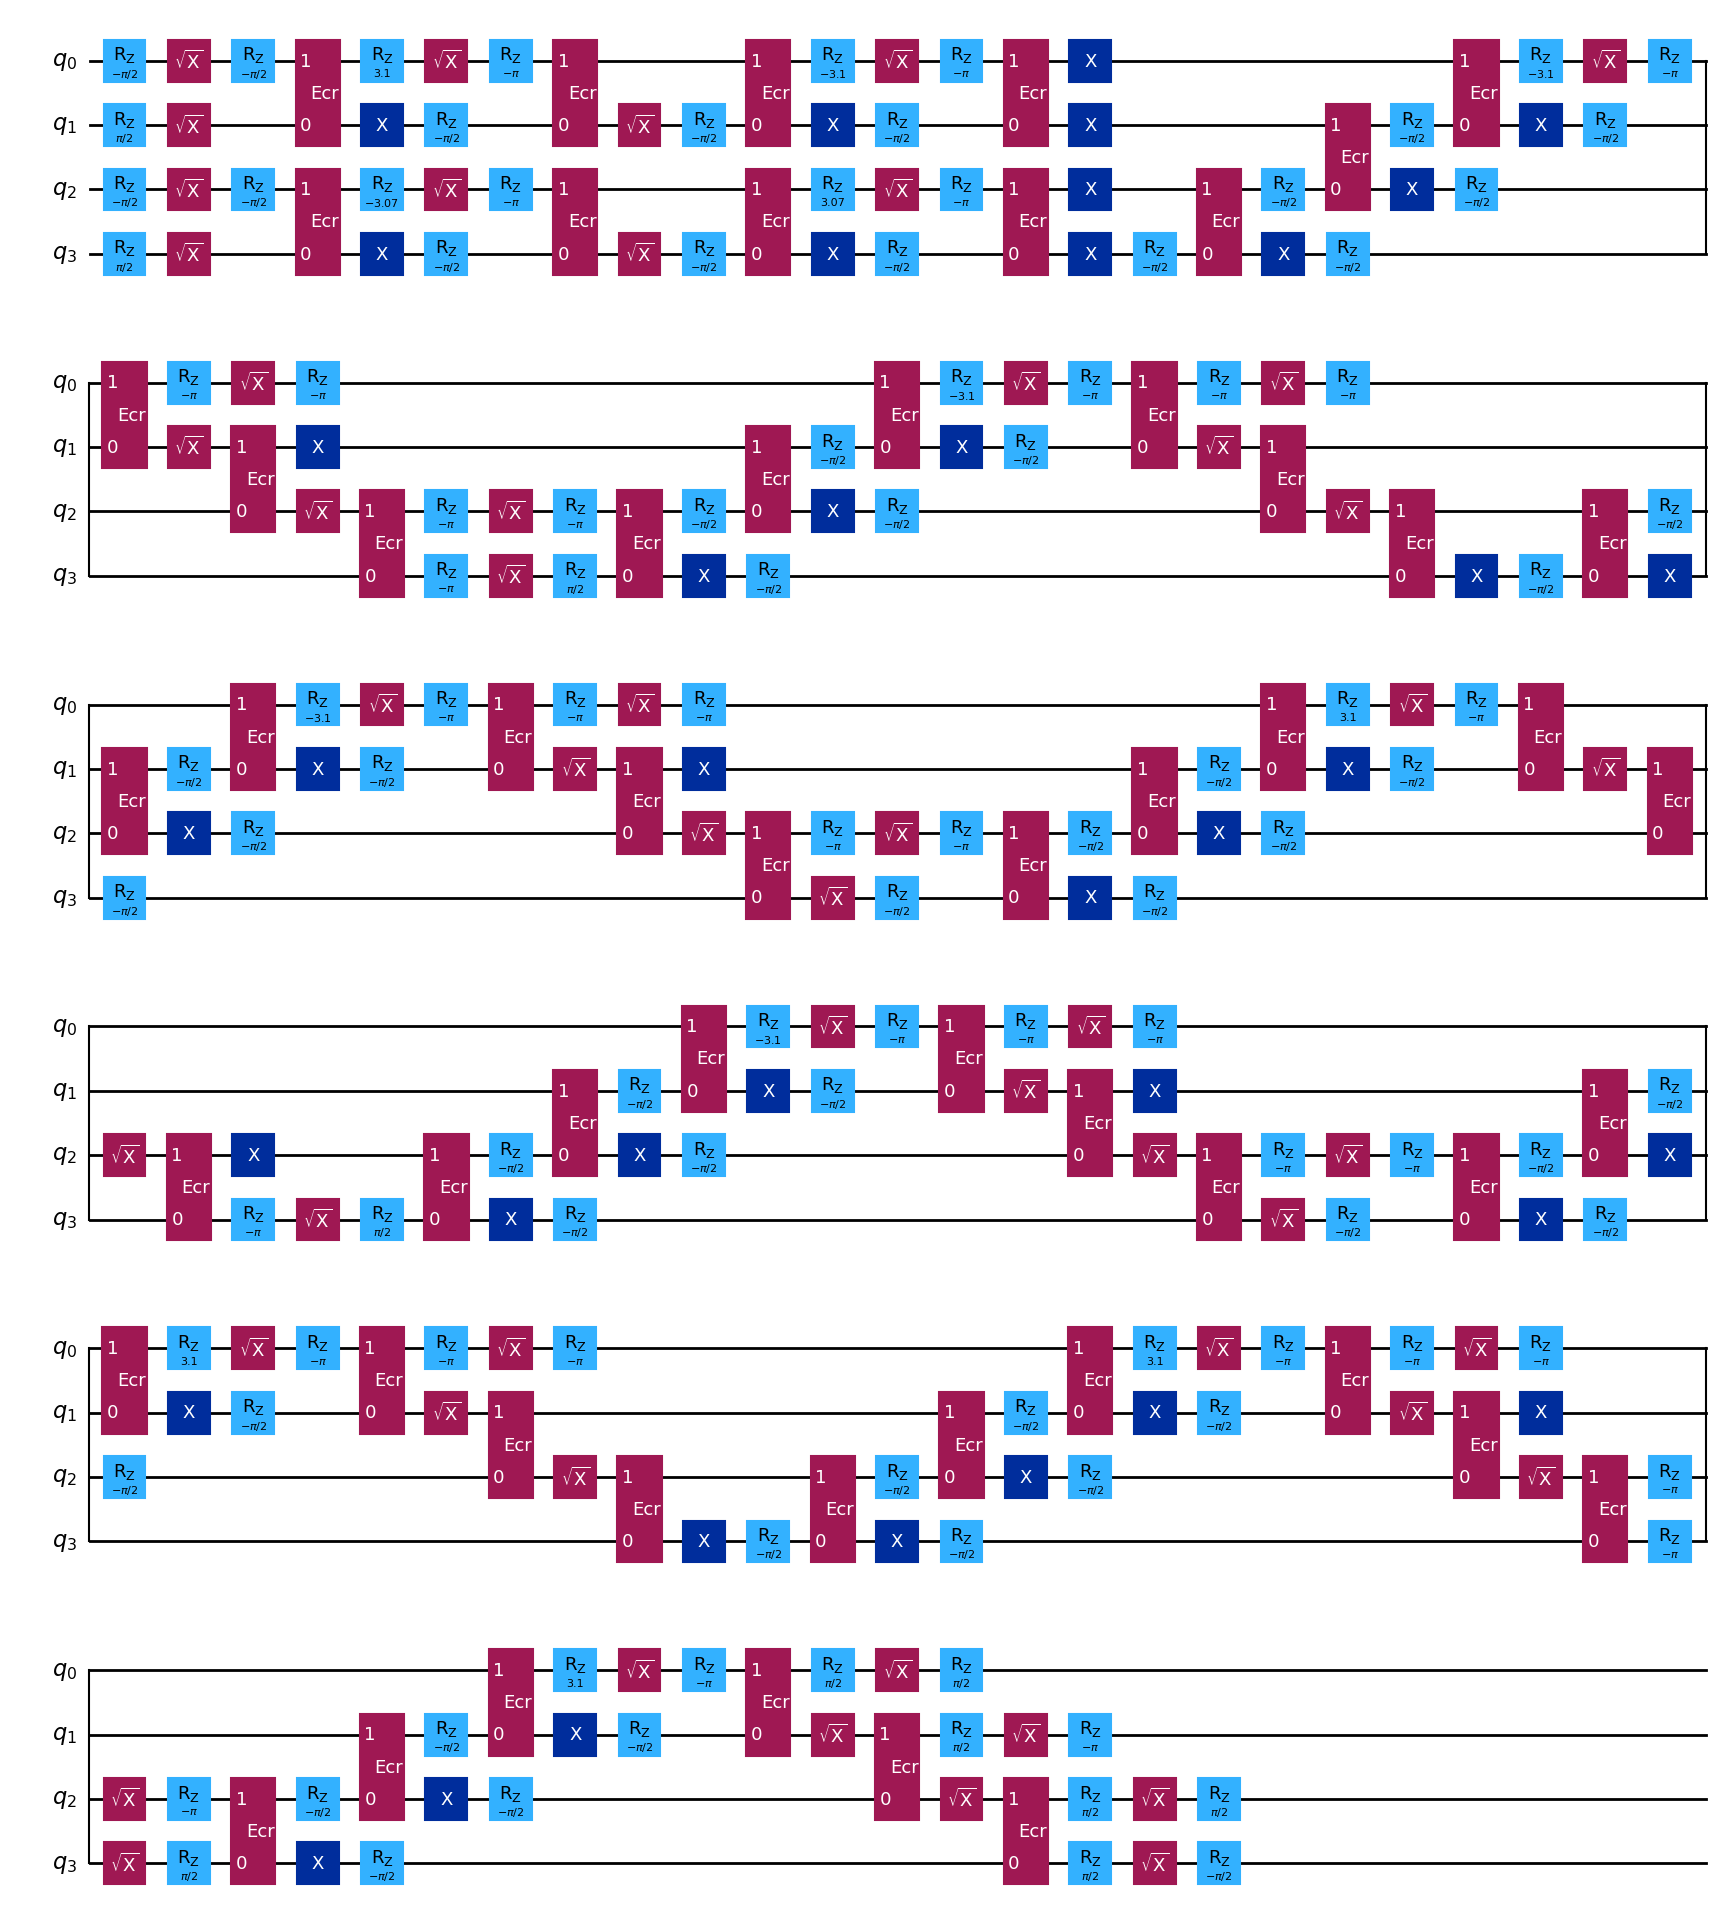

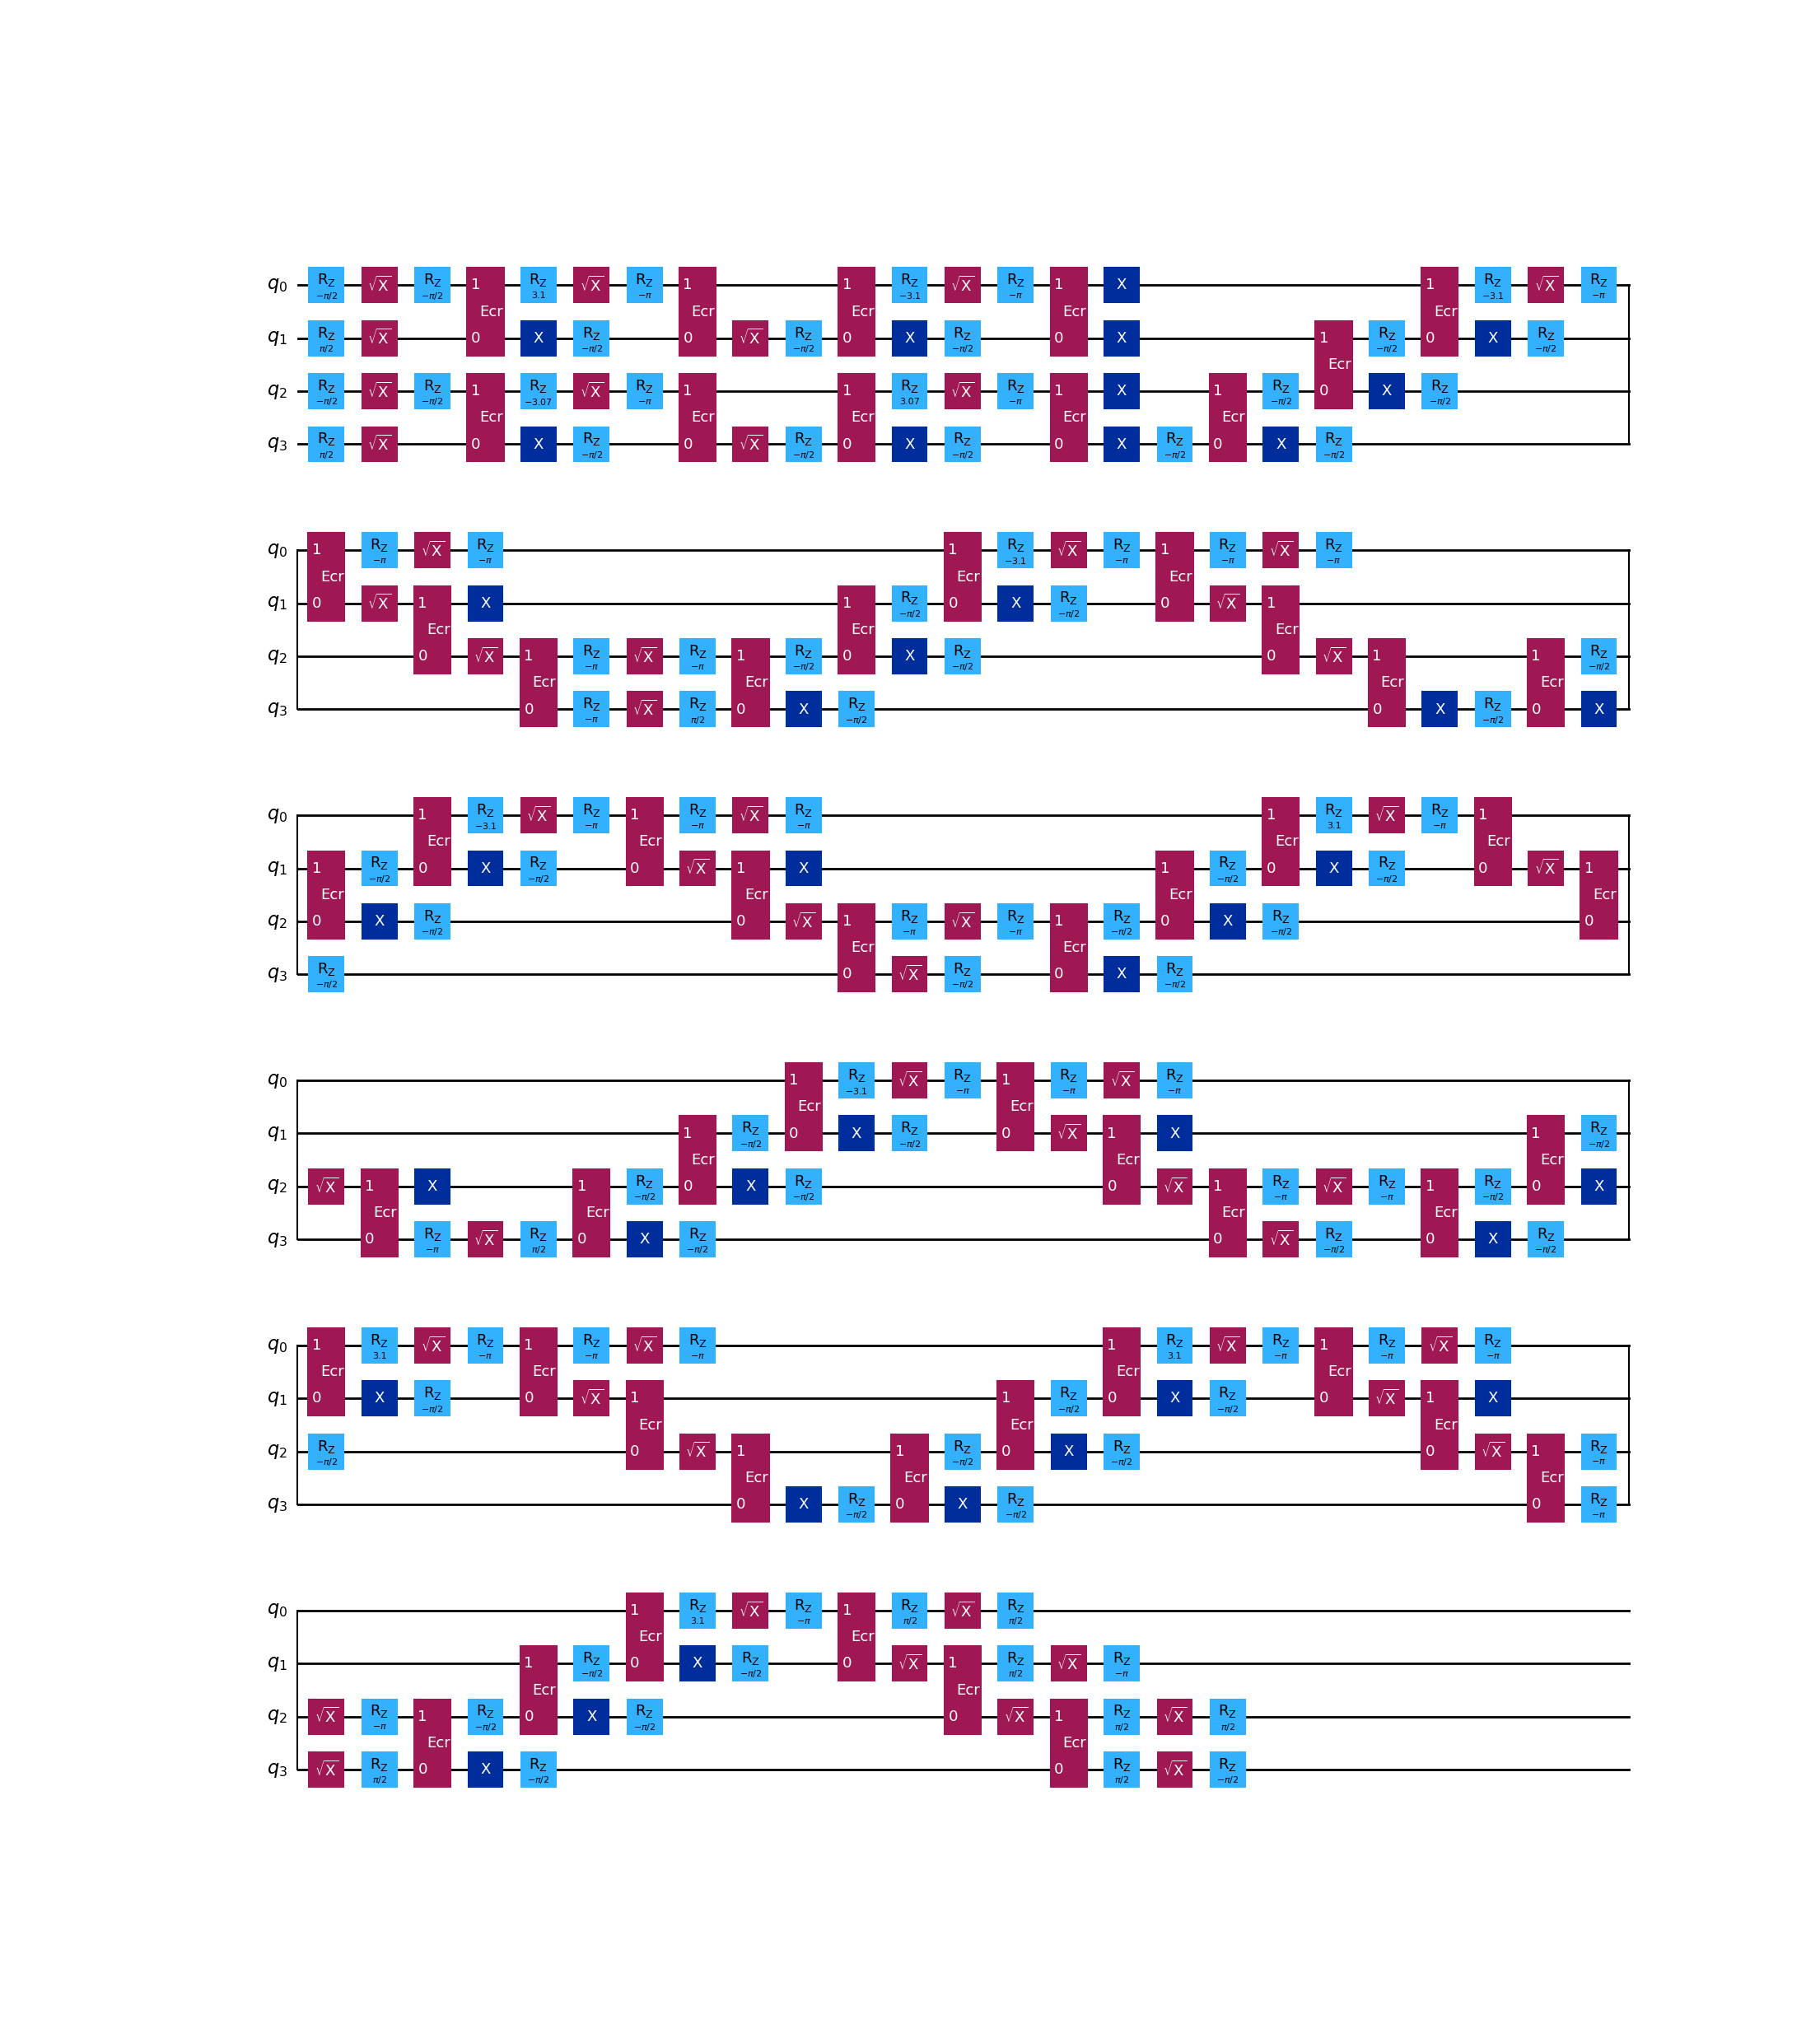

In [28]:
circuito_ibm.draw(output='mpl')

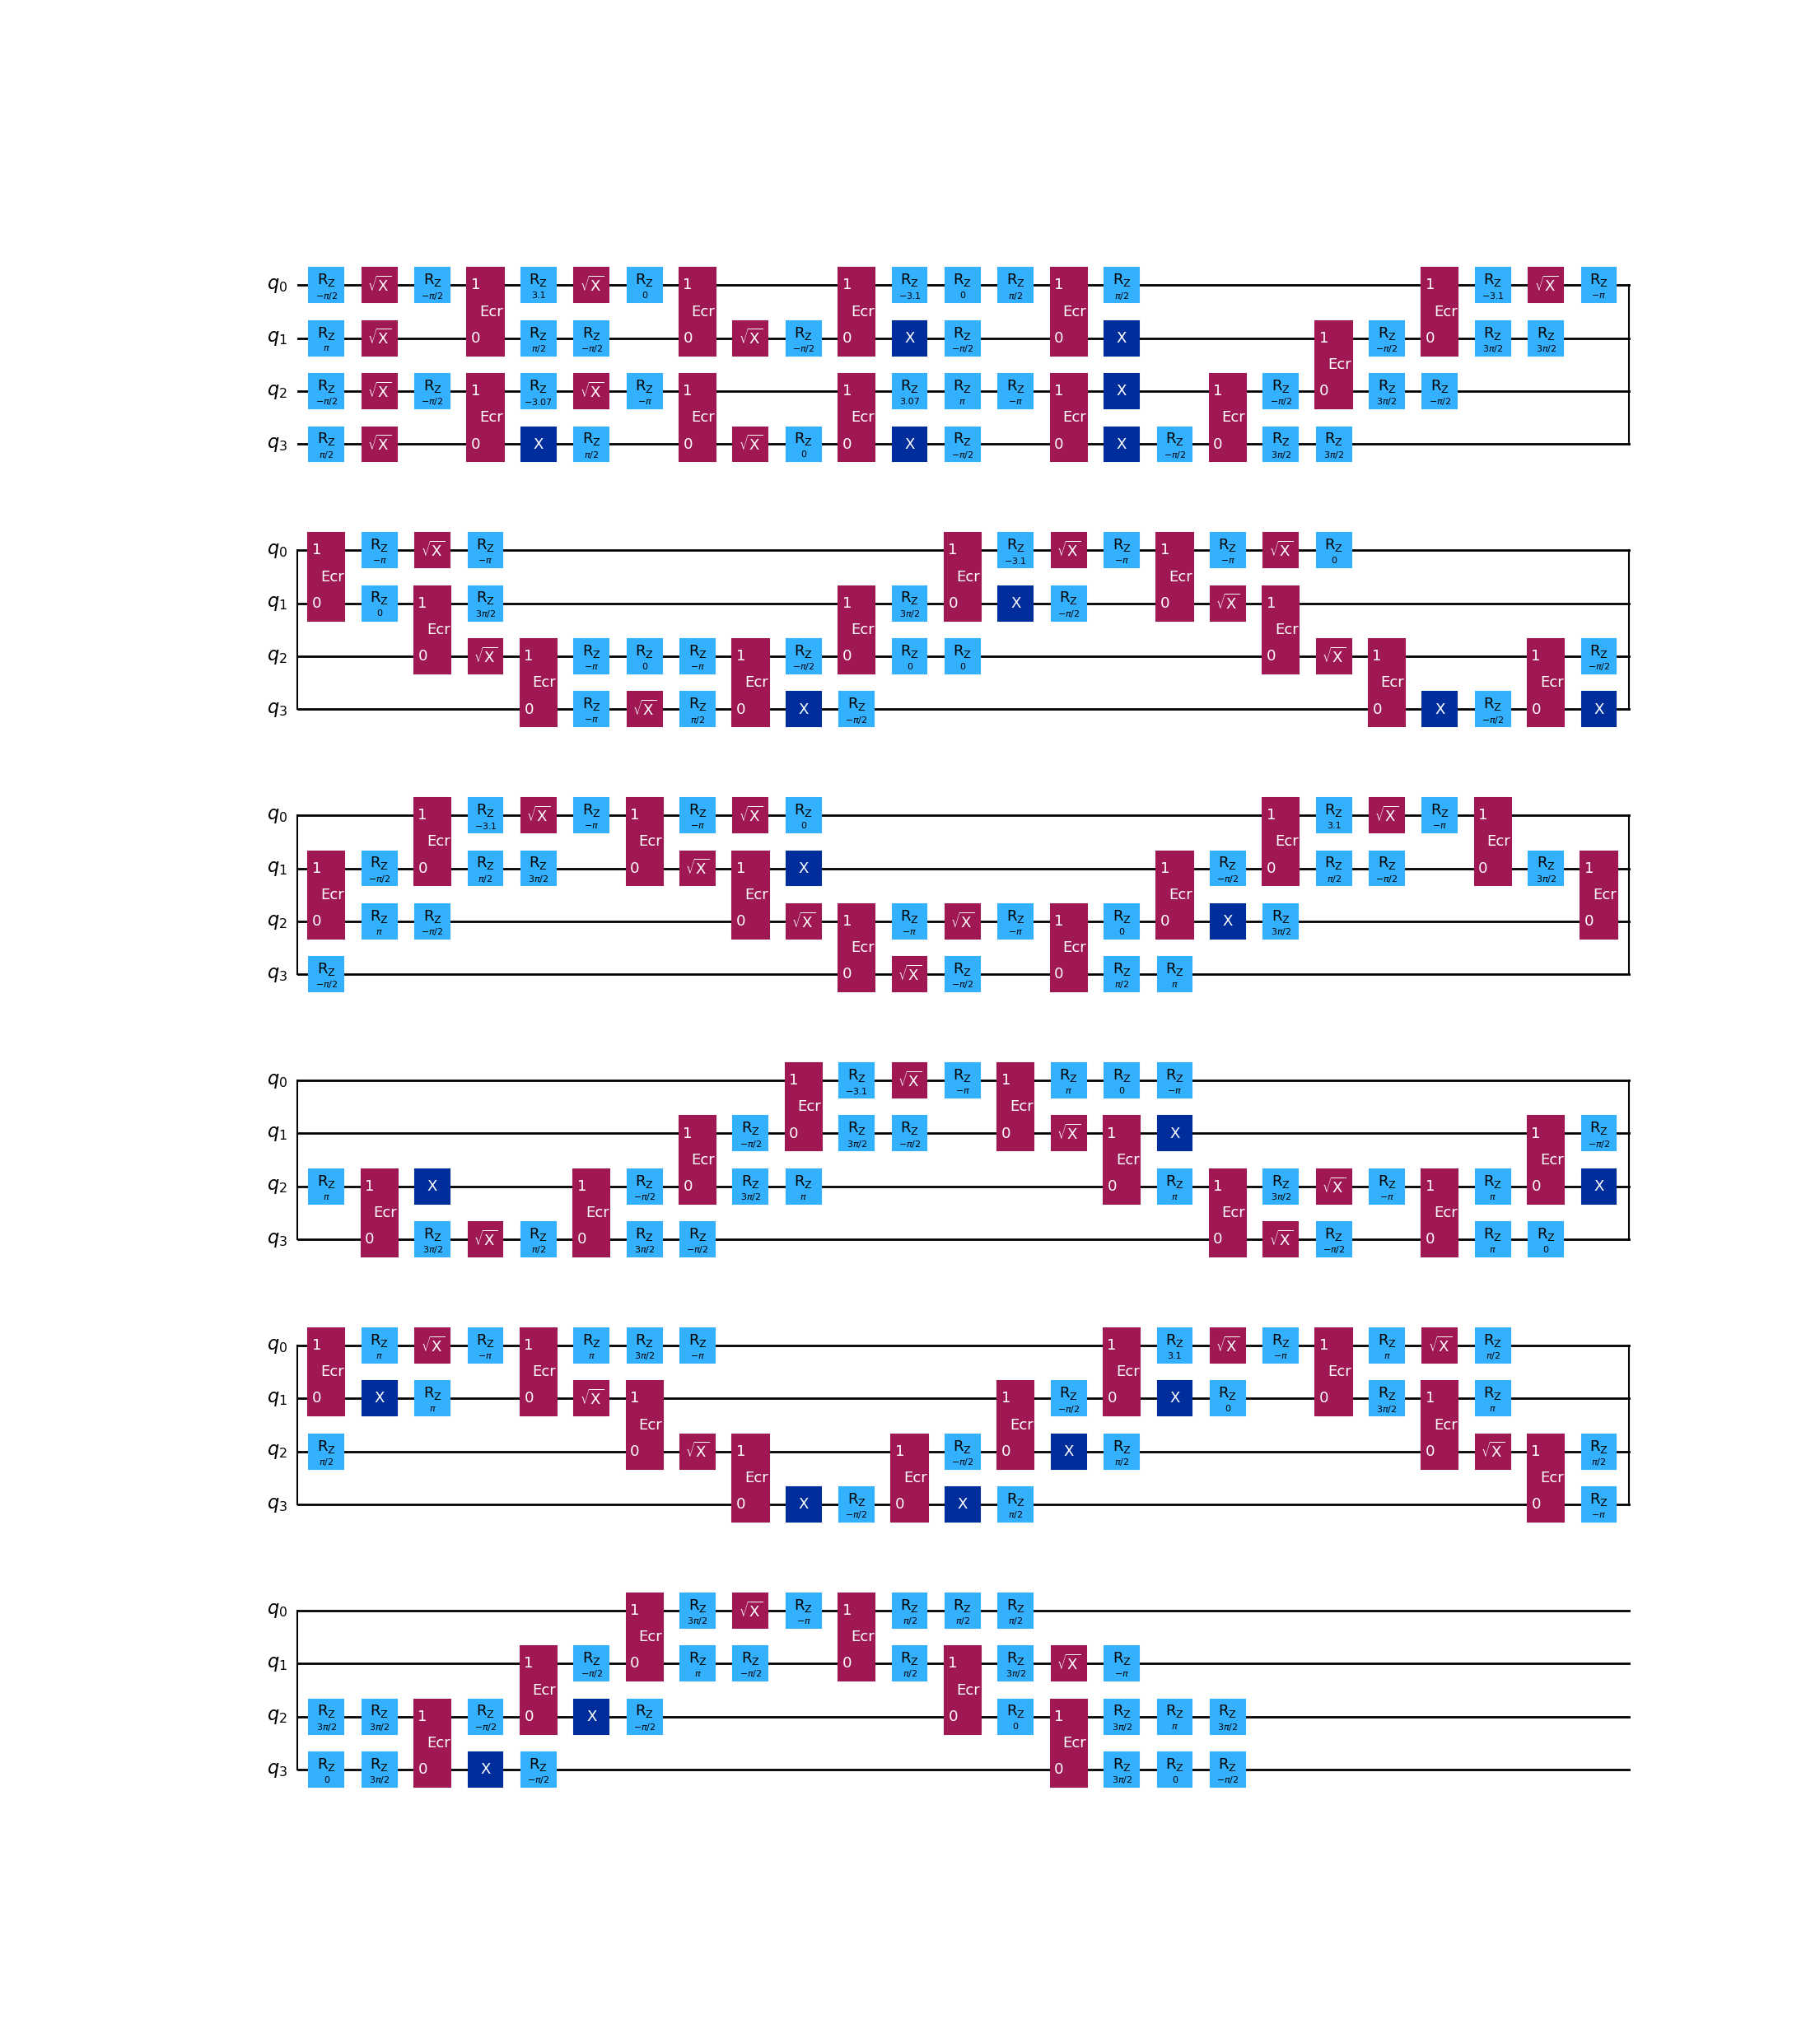

In [27]:
circuito = list(modelo_1(circuito_ibm, 1, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = 'estimator_aer', shots = None, seed = 1))[0][0].draw(output='mpl')

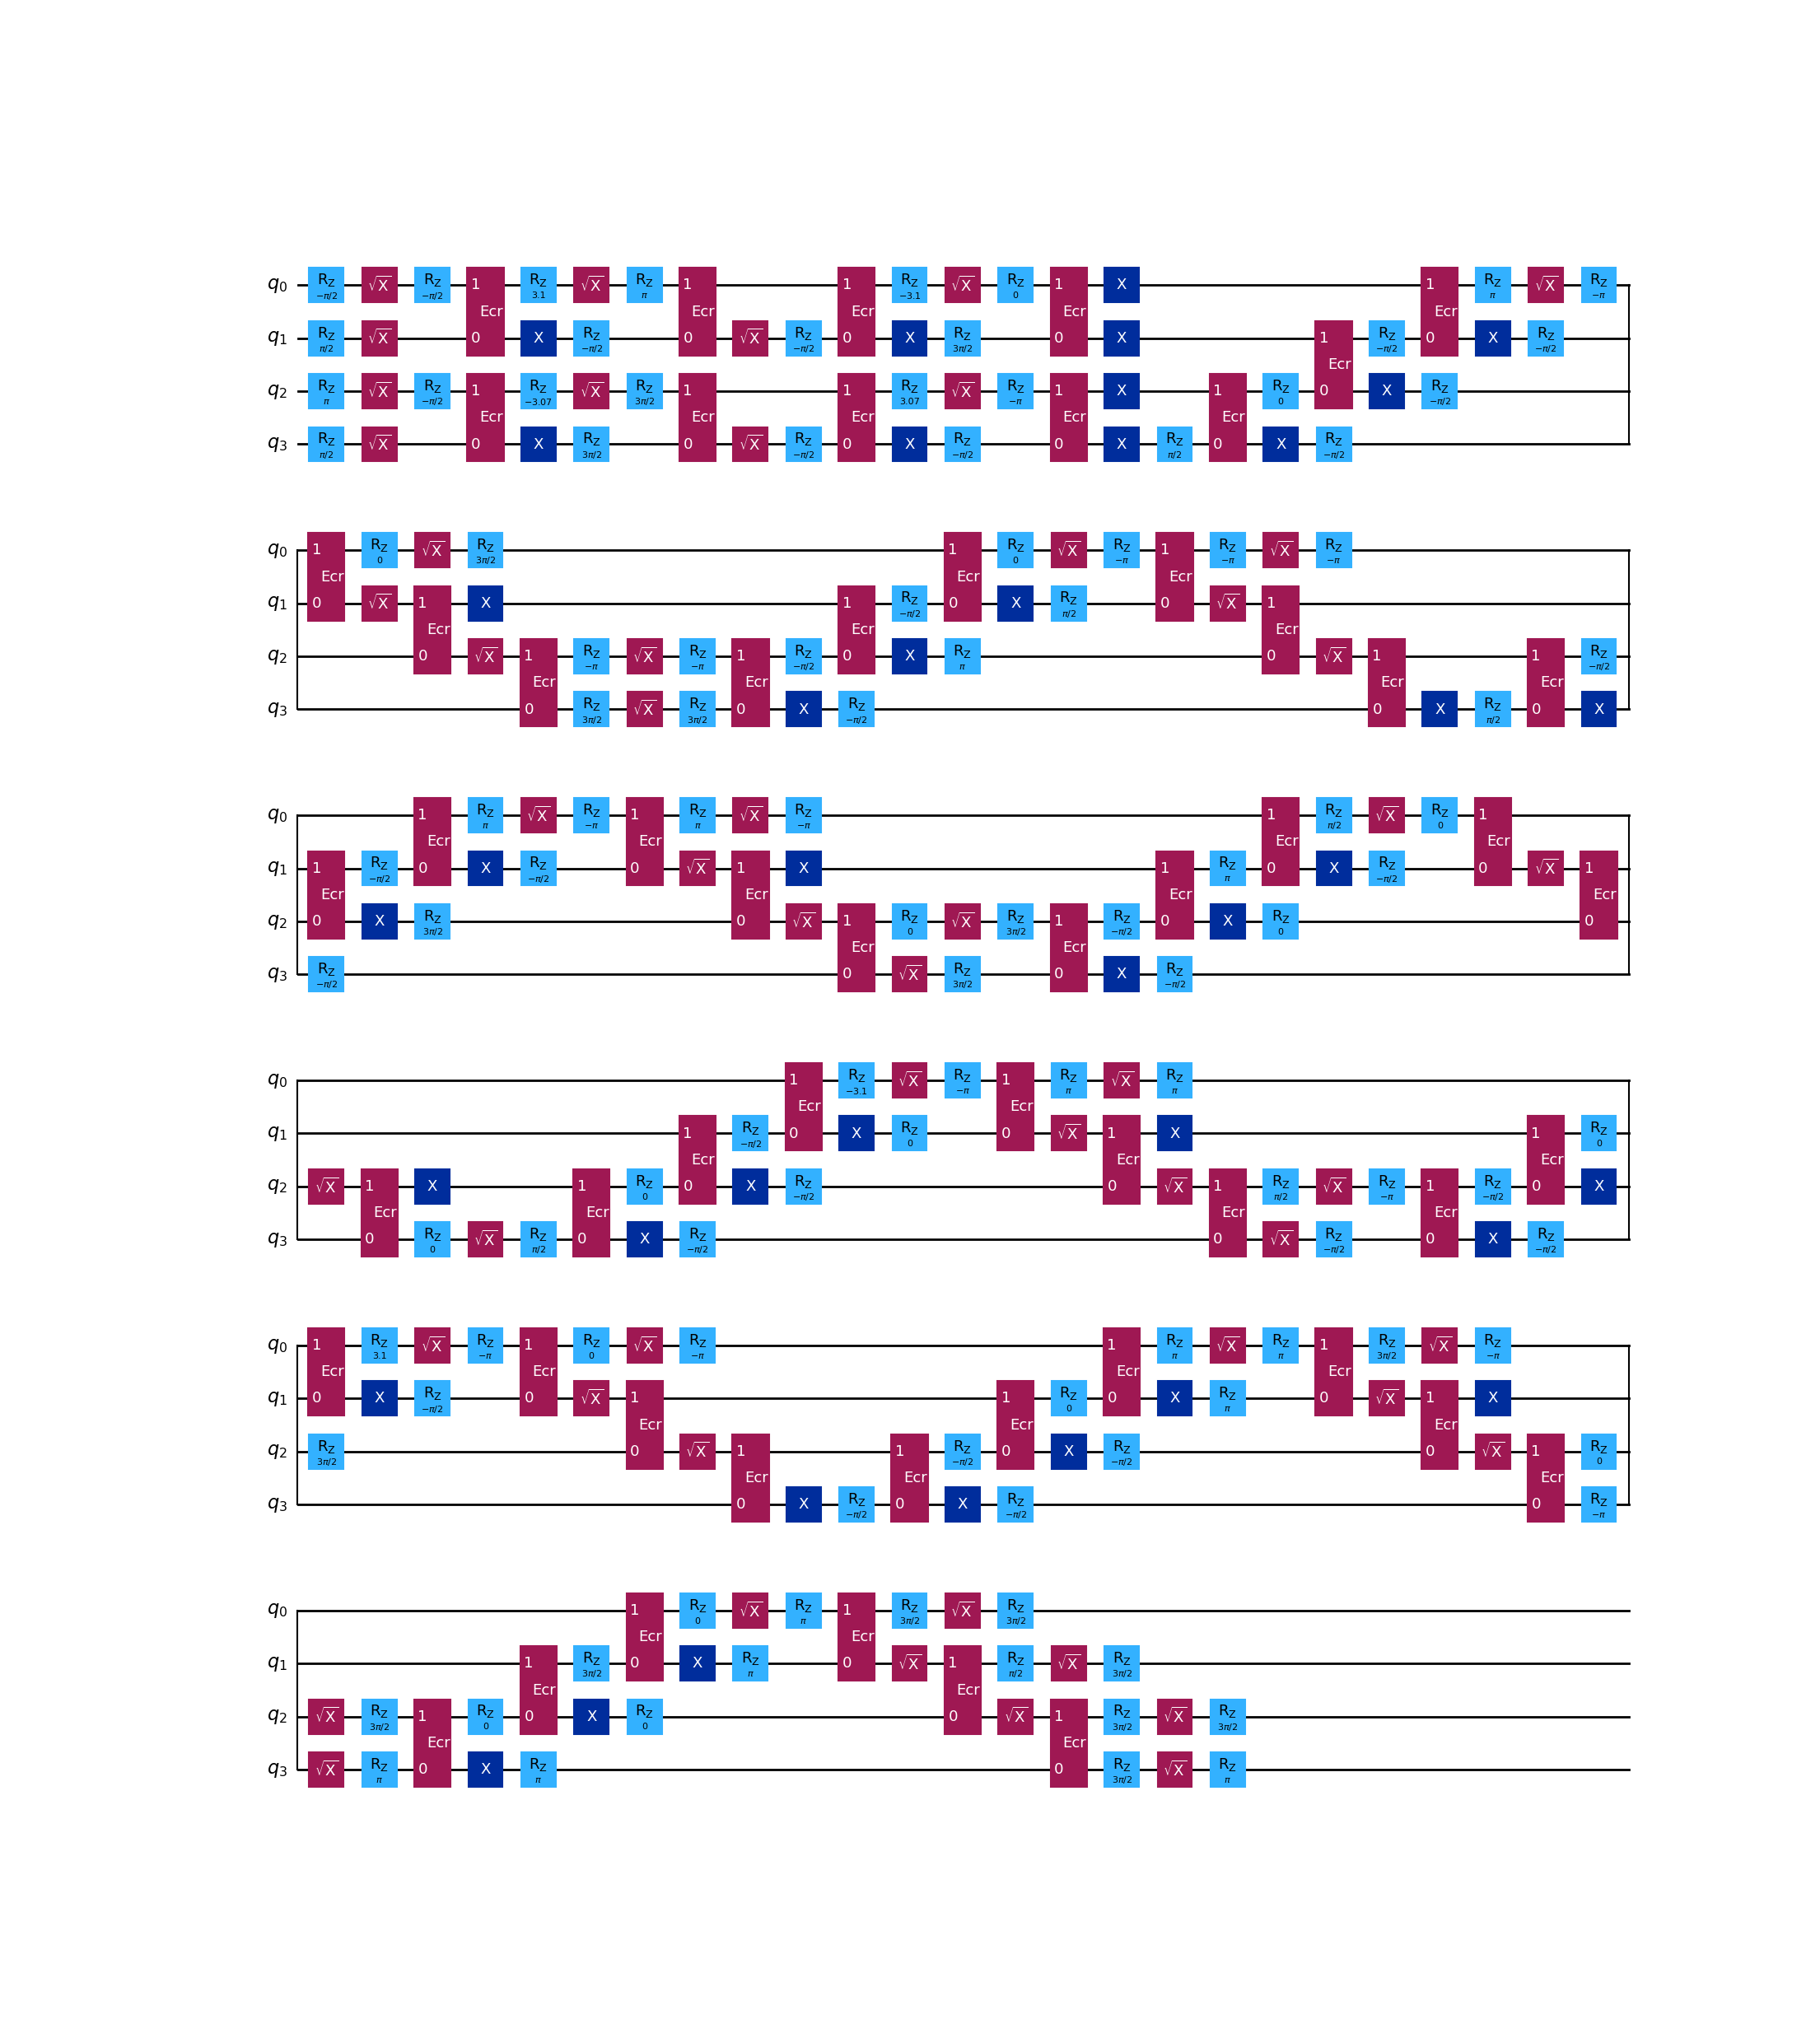

In [29]:
circuito2 = list(modelo_2(circuito_ibm, 1, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = 'estimator_aer', shots = None, seed = 1))[0][0].draw(output='mpl')

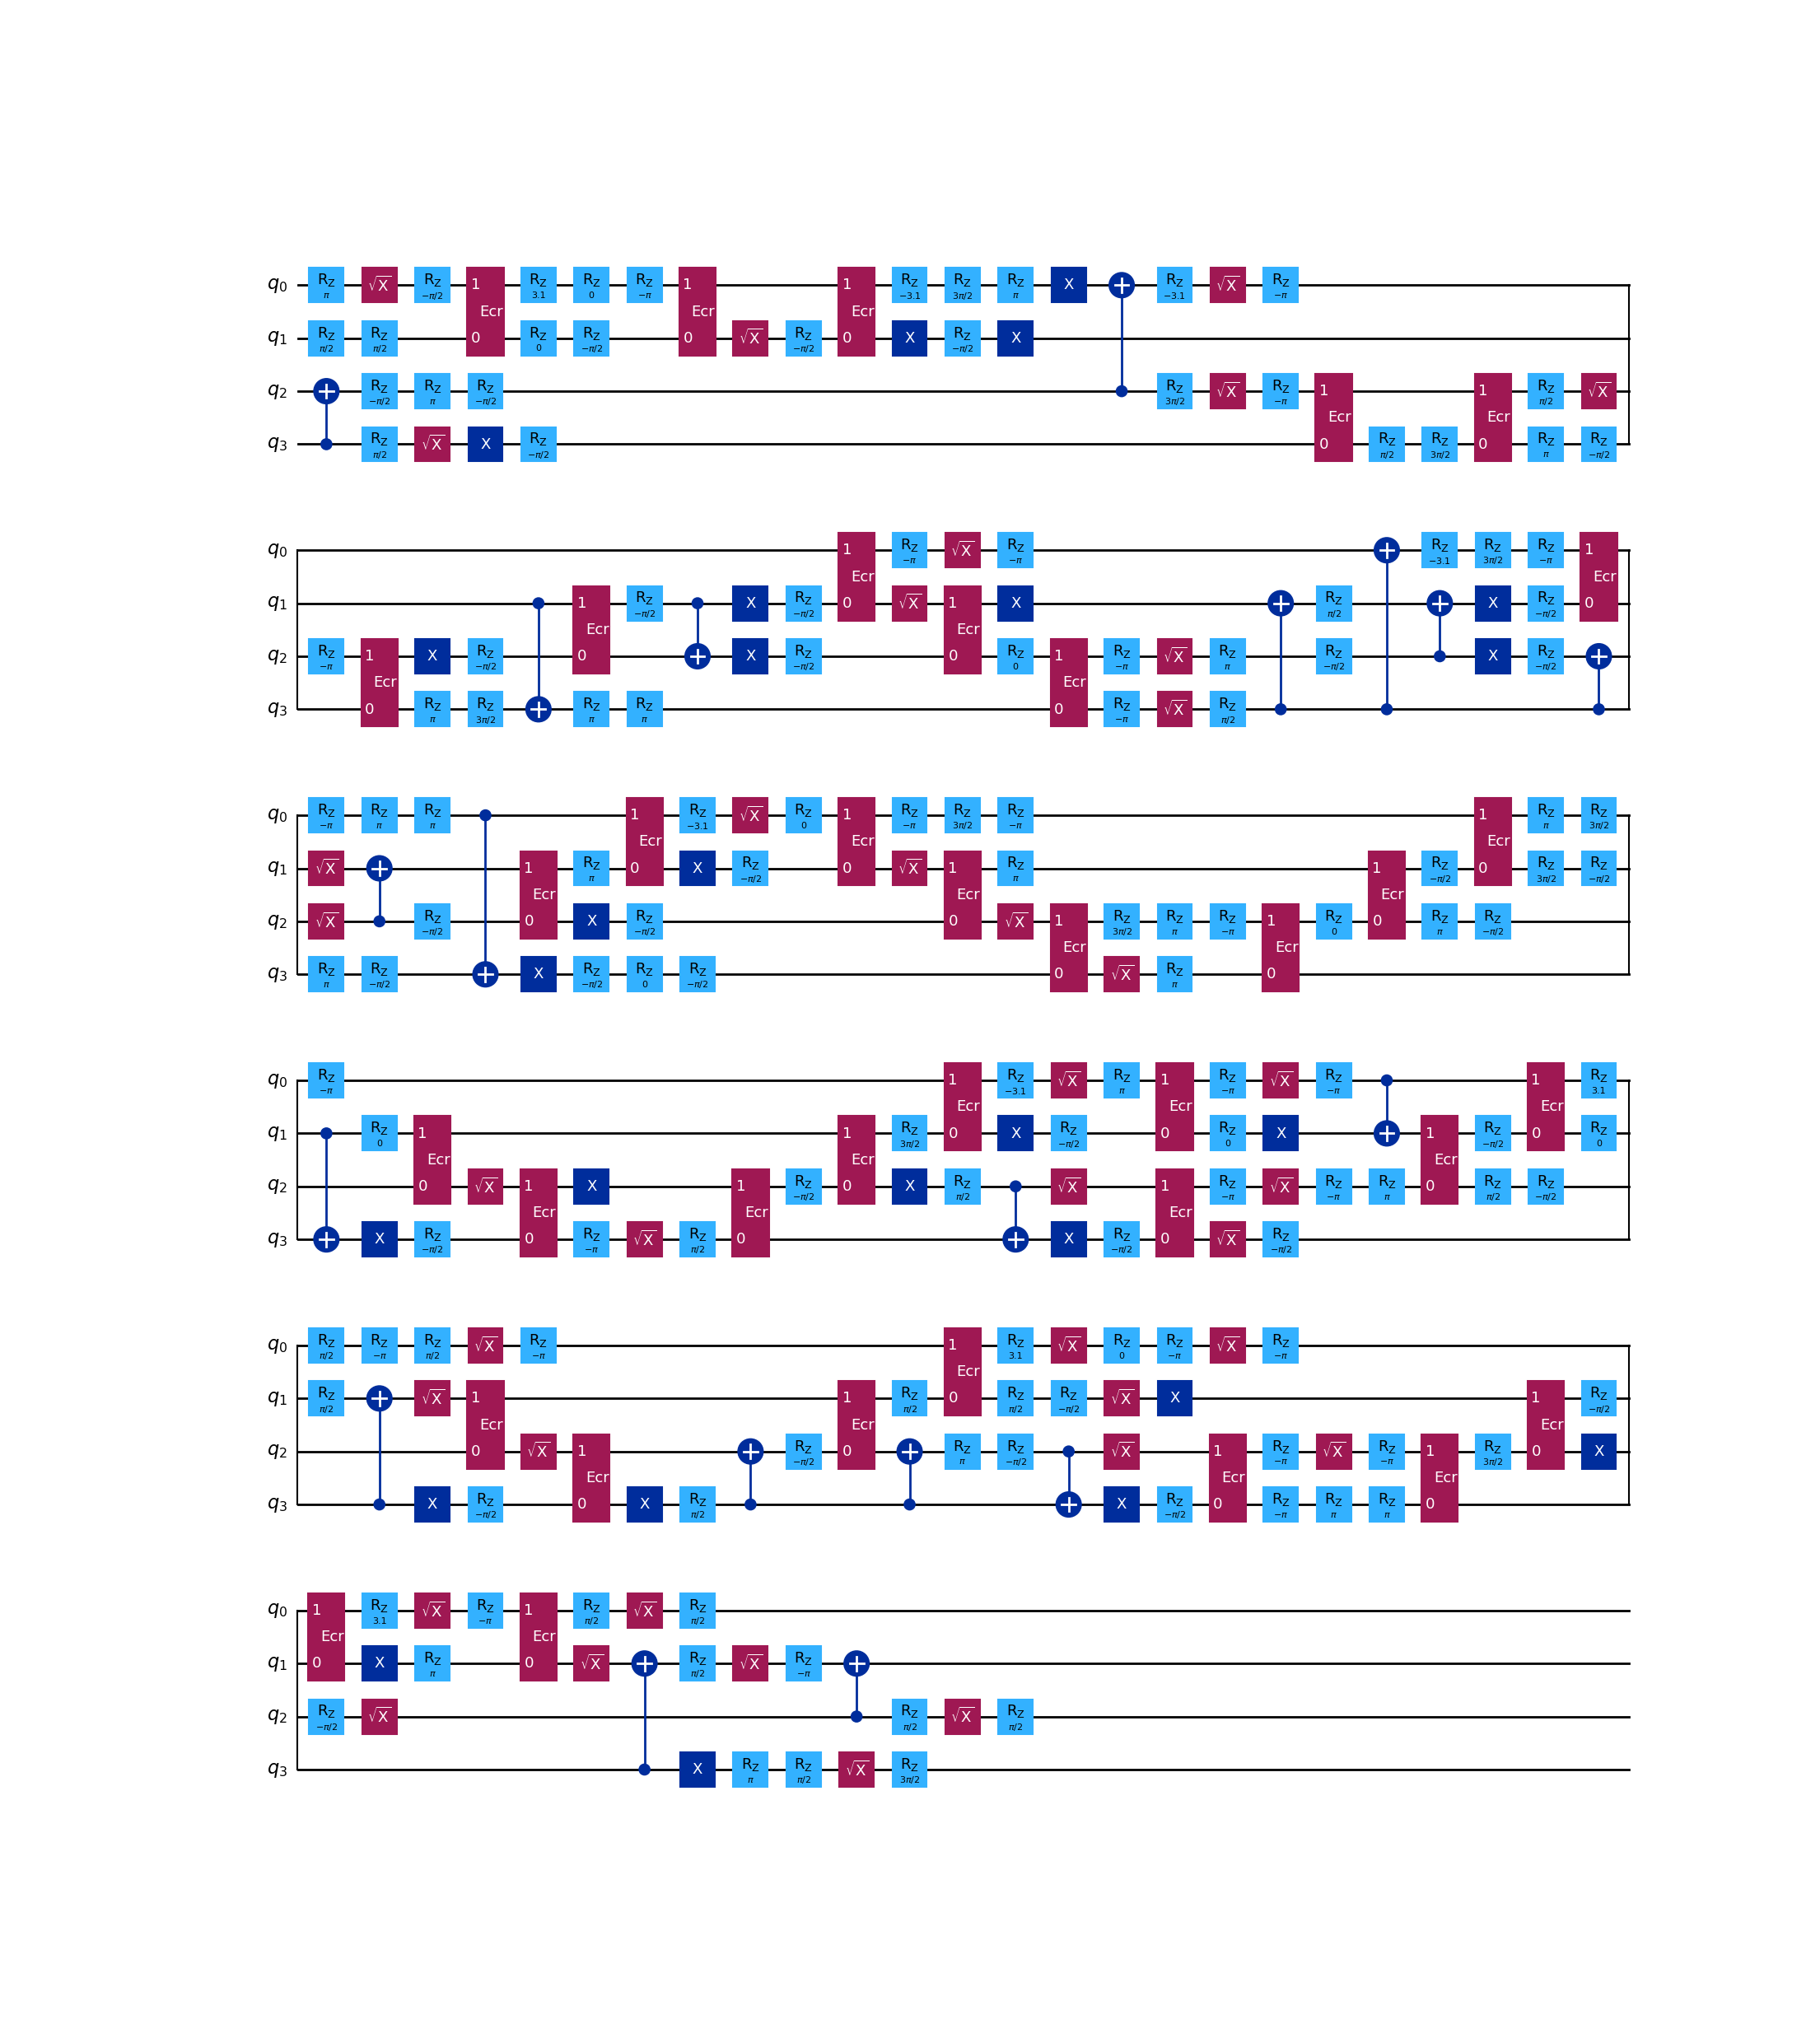

In [51]:
circuito3 = list(modelo_3(circuito_ibm, 1, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = 'estimator_aer', shots = None, seed = 1))[0][0].draw(output='mpl')

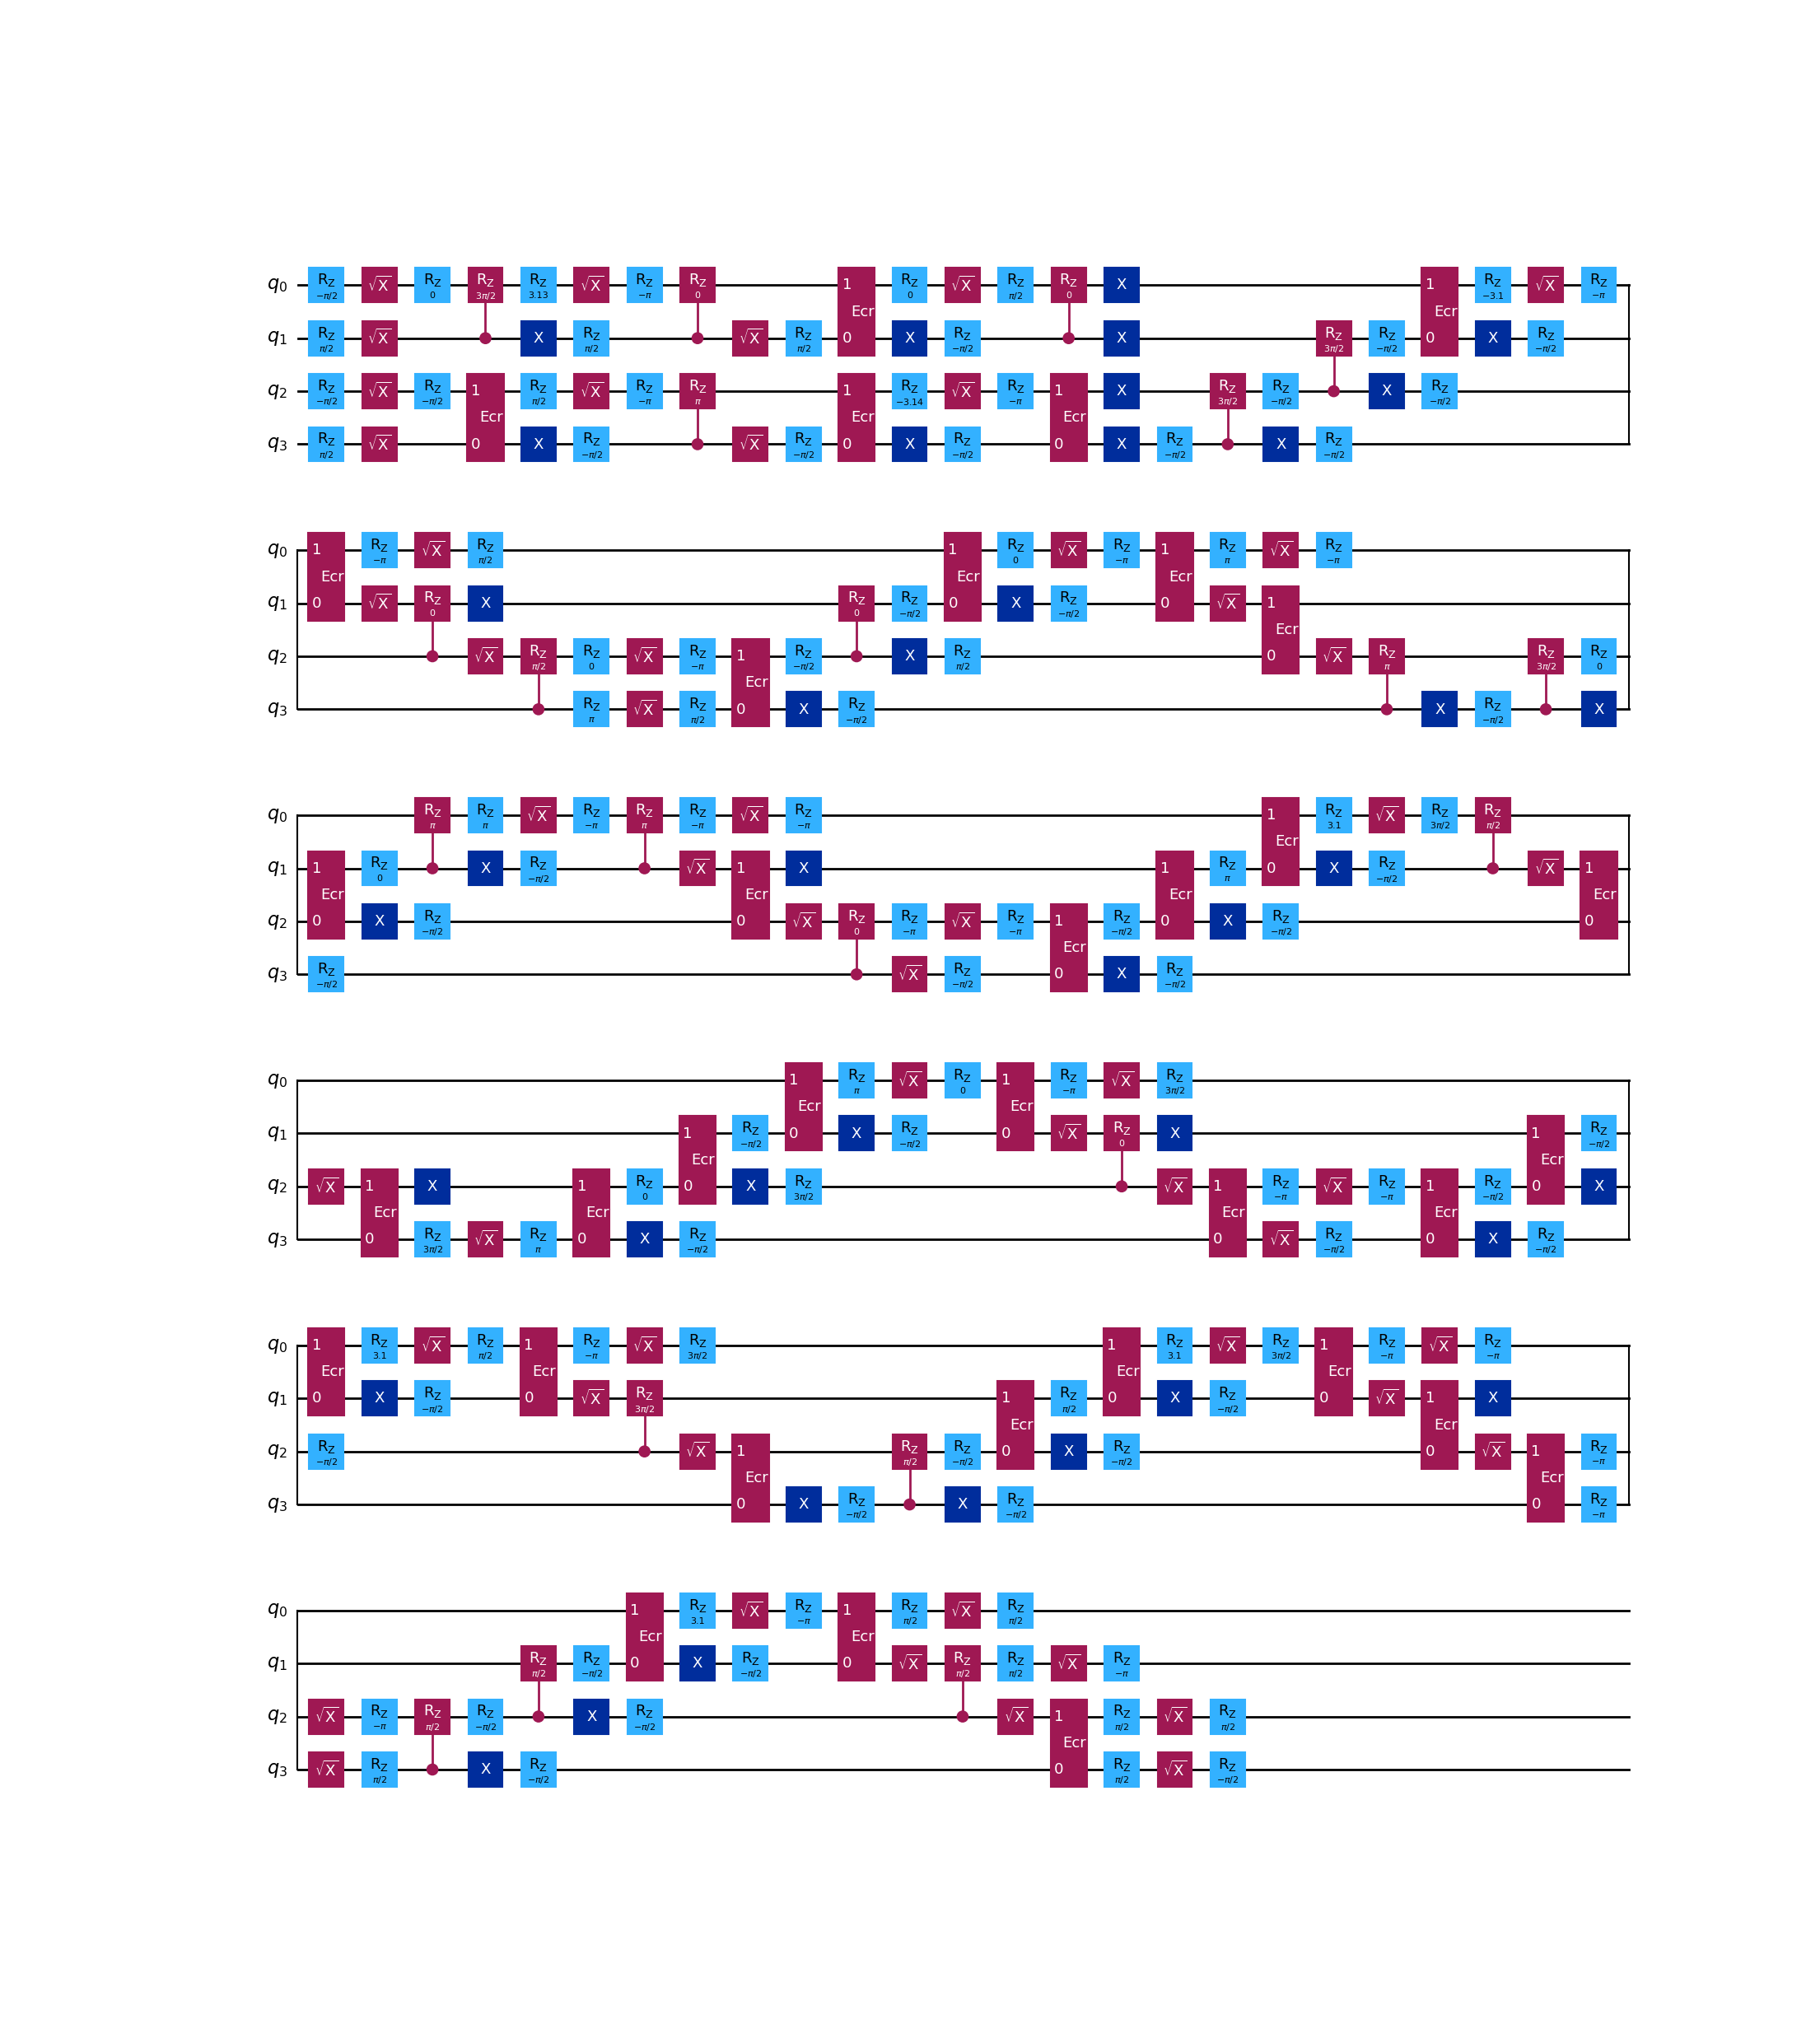

In [10]:
circuito4 = list(modelo_4(circuito_ibm, 1, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = 'estimator_aer', shots = None, seed = 1))[0][0].draw(output='mpl')

# Rodando modelos

# Modelo 1

# Modelo 2

# Modelo 3

# Modelo 4